<a href="https://colab.research.google.com/github/p-jisung/sharp28/blob/main/nba_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install nba_api
!pip install unidecode
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import unidecode
import numpy as np
import random
import json
import pickle

from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

# PREPARE DATA

In [5]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Stats

In [6]:
COLUMNS = [
    "PLAYER",
    "GP",
    "MIN",
    "FGM",
    "FGA",
    "FG_PCT",
    "FG3M",
    "FG3A",
    "FG3_PCT",
    "FTM",
    "FTA",
    "FT_PCT",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "STL",
    "BLK",
    "TOV",
    "PF",
    "PTS",
    "EFF",
    "AST_TOV",
    "STL_TOV",
]
SEASONS_FROM = 1989
SEASONS_TO = 2023
DROP = [1995, 2001]  # More winners than usual in rookies

SEASONS = [
    f"{season}-{(season+1)%100:02d}"
    for season in range(SEASONS_FROM, SEASONS_TO + 1)
    if season not in DROP
]

In [7]:
print(f"Seasons: {SEASONS}")

Seasons: ['1989-90', '1990-91', '1991-92', '1992-93', '1993-94', '1994-95', '1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']


In [8]:
def get_players_stats(seasons, rookies_only=False):
    seasons_stats = pd.DataFrame()
    scope = "Rookies" if rookies_only else "S"

    for season in seasons:
        player_stats = leagueleaders.LeagueLeaders(
            season=season, scope=scope
        ).get_data_frames()[0][COLUMNS]
        player_stats.columns = pd.MultiIndex.from_product(
            [[season], player_stats.columns]
        )
        seasons_stats = pd.concat([seasons_stats, player_stats], axis=1)

    return seasons_stats

In [9]:
stats_all_nba_df = get_players_stats(seasons=SEASONS)
stats_all_nba_df.to_csv(DATA_DIR / "stats_all_nba.csv")
stats_all_nba_df

1989-90                                                    \
                PLAYER    GP     MIN     FGM     FGA FG_PCT  FG3M   FG3A   
0       Michael Jordan  82.0  3197.0  1034.0  1964.0  0.526  92.0  245.0   
1          Karl Malone  82.0  3122.0   914.0  1627.0  0.562  16.0   43.0   
2        Patrick Ewing  82.0  3165.0   922.0  1673.0  0.551   1.0    4.0   
3         Tom Chambers  81.0  3046.0   810.0  1617.0  0.501  24.0   86.0   
4    Dominique Wilkins  80.0  2888.0   810.0  1672.0  0.484  59.0  183.0   
..                 ...   ...     ...     ...     ...    ...   ...    ...   
600                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
601                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
602                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
603                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
604                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   

                    ... 2023-24                                            \
    FG3_PCT    FTM  ...     REB    AST    STL   BLK    TOV     PF     PTS   
0     0.376  593.0  ...   647.0  686.0   99.0  38.0  282.0  149.0  2370.0   
1     0.372  696.0  ...   415.0  465.0  150.0  67.0  162.0  184.0  2254.0   
2     0.250  502.0  ...   841.0  476.0   87.0  79.0  250.0  210.0  2222.0   
3     0.279  557.0  ...   278.0  519.0   70.0  13.0  186.0  144.0  2212.0   
4     0.322  459.0  ...   976.0  708.0  108.0  68.0  237.0  194.0  2085.0   
..      ...    ...  ...     ...    ...    ...   ...    ...    ...     ...   
600     NaN    NaN  ...     NaN    NaN    NaN   NaN    NaN    NaN     NaN   
601     NaN    NaN  ...     NaN    NaN    NaN   NaN    NaN    NaN     NaN   
602     NaN    NaN  ...     NaN    NaN    NaN   NaN    NaN    NaN     NaN   
603     NaN    NaN  ...     NaN    NaN    NaN   NaN    NaN    NaN     NaN   
604     NaN    NaN  ...     NaN    NaN    NaN   NaN    NaN    NaN     NaN   

                             
        EFF AST_TOV STL_TOV  
0    2580.0    2.43    0.35  
1    2416.0    2.87    0.93  
2    2655.0    1.90    0.35  
3    1972.0    2.79    0.38  
4    3039.0    2.99    0.46  
..      ...     ...     ...  
600     NaN     NaN     NaN  
601     NaN     NaN     NaN  
602     NaN     NaN     NaN  
603     NaN     NaN     NaN  
604     NaN     NaN     NaN  

[605 rows x 792 columns]

In [10]:
stats_all_rookie_df = get_players_stats(seasons=SEASONS, rookies_only=True)
stats_all_rookie_df.to_csv(DATA_DIR / "stats_all_rookie.csv")
stats_all_rookie_df

1989-90                                                          \
              PLAYER    GP     MIN    FGM     FGA FG_PCT  FG3M  FG3A FG3_PCT   
0     David Robinson  82.0  3002.0  690.0  1300.0  0.531   0.0   2.0   0.000   
1       Tim Hardaway  79.0  2663.0  464.0   985.0  0.471  23.0  84.0   0.274   
2    Sherman Douglas  81.0  2470.0  463.0   938.0  0.494   5.0  31.0   0.161   
3          Glen Rice  77.0  2311.0  470.0  1071.0  0.439  17.0  69.0   0.246   
4       Sam Mitchell  80.0  2414.0  372.0   834.0  0.446   0.0   9.0   0.000   
..               ...   ...     ...    ...     ...    ...   ...   ...     ...   
105              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
106              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
107              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
108              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
109              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   

            ... 2023-24                                                    \
       FTM  ...     REB    AST   STL    BLK    TOV     PF     PTS     EFF   
0    613.0  ...   755.0  274.0  88.0  254.0  260.0  153.0  1522.0  1923.0   
1    211.0  ...   648.0  200.0  53.0  190.0  131.0  197.0  1357.0  1812.0   
2    224.0  ...   315.0  175.0  66.0   42.0  132.0  184.0  1279.0  1108.0   
3     91.0  ...   211.0  332.0  36.0    7.0  188.0   91.0   974.0   842.0   
4    268.0  ...   285.0  195.0  77.0   20.0  110.0  167.0   889.0   967.0   
..     ...  ...     ...    ...   ...    ...    ...    ...     ...     ...   
105    NaN  ...     NaN    NaN   NaN    NaN    NaN    NaN     NaN     NaN   
106    NaN  ...     NaN    NaN   NaN    NaN    NaN    NaN     NaN     NaN   
107    NaN  ...     NaN    NaN   NaN    NaN    NaN    NaN     NaN     NaN   
108    NaN  ...     NaN    NaN   NaN    NaN    NaN    NaN     NaN     NaN   
109    NaN  ...     NaN    NaN   NaN    NaN    NaN    NaN     NaN     NaN   

                     
    AST_TOV STL_TOV  
0      1.05    0.34  
1      1.53    0.41  
2      1.33    0.50  
3      1.77    0.19  
4      1.77    0.70  
..      ...     ...  
105     NaN     NaN  
106     NaN     NaN  
107     NaN     NaN  
108     NaN     NaN  
109     NaN     NaN  

[110 rows x 792 columns]

## Awards

In [11]:
HARDCODED_REPLACE = {
    "Amare Stoudemire": "Amar'e Stoudemire",
    "Akeem Olajuwon": "Hakeem Olajuwon",
    "Nene Hilario": "Nene",
    "Ron Artest": "Metta World Peace",
    "Penny Hardaway": "Anfernee Hardaway",
    "Chris Jackson": "Mahmoud Abdul-Rauf",
    "Steve Smith": "Steven Smith",
    "Clarence Weatherspoon": "Clar. Weatherspoon",
    "Dino Rada": "Dino Radja",
}

In [12]:
def postprocess_award(award):

    award = award.droplevel(0, axis=1)
    award = award.drop(columns=["Teams", "Positions"], errors="ignore")
    award = award.set_index("Season")
    award.index = award.index.map(lambda x: x.replace("\u2013", "-"))

    postprocessed_award = pd.DataFrame()
    for index in SEASONS:
        season = award.loc[index]
        season = pd.concat(values for _, values in season.items())
        season = season.reset_index(drop=True)
        season = season.str.replace(r"[\*\^\[\(\†\§].*", "", regex=True)
        season = season.str.replace(r"\. ", ".", n=1, regex=True)
        season = season.apply(unidecode.unidecode)

        for k, v in HARDCODED_REPLACE.items():
            season = season.str.replace(k, v)

        season = season.str.rstrip()
        postprocessed_award = postprocessed_award.assign(**{index: season})

    return postprocessed_award

In [13]:
awards_all_nba_df = pd.read_html("https://en.wikipedia.org/wiki/All-NBA_Team")[7:9]
awards_all_nba_df = pd.concat(awards_all_nba_df)
awards_all_nba_df = postprocess_award(awards_all_nba_df)
awards_all_nba_df.to_csv(DATA_DIR / "awards_all_nba.csv")
awards_all_nba_df

,1989-90,1990-91,1991-92,1992-93,1993-94,1994-95,1996-97,1997-98,1998-99,1999-00,...,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24
0,Karl Malone,Karl Malone,Karl Malone,Charles Barkley,Scottie Pippen,Karl Malone,Karl Malone,Karl Malone,Karl Malone,Tim Duncan,...,LeBron James,Kawhi Leonard,Kawhi Leonard,Kevin Durant,Giannis Antetokounmpo,LeBron James,Giannis Antetokounmpo,Giannis Antetokounmpo,Giannis Antetokounmpo,Shai Gilgeous-Alexander
1,Charles Barkley,Charles Barkley,Chris Mullin,Karl Malone,Karl Malone,Scottie Pippen,Grant Hill,Tim Duncan,Tim Duncan,Kevin Garnett,...,Anthony Davis,LeBron James,LeBron James,LeBron James,Paul George,Giannis Antetokounmpo,Kawhi Leonard,Jayson Tatum,Jayson Tatum,Nikola Jokic
2,Patrick Ewing,David Robinson,David Robinson,Hakeem Olajuwon,Hakeem Olajuwon,David Robinson,Hakeem Olajuwon,Shaquille O'Neal,Alonzo Mourning,Shaquille O'Neal,...,Marc Gasol,DeAndre Jordan,Anthony Davis,Anthony Davis,Nikola Jokic,Anthony Davis,Nikola Jokic,Nikola Jokic,Joel Embiid,Luka Doncic
3,Magic Johnson,Michael Jordan,Michael Jordan,Michael Jordan,John Stockton,John Stockton,Michael Jordan,Michael Jordan,Allen Iverson,Jason Kidd,...,James Harden,Stephen Curry,James Harden,James Harden,James Harden,James Harden,Stephen Curry,Devin Booker,Luka Doncic,Giannis Antetokounmpo
4,Michael Jordan,Magic Johnson,Clyde Drexler,Mark Price,Latrell Sprewell,Anfernee Hardaway,Tim Hardaway,Gary Payton,Jason Kidd,Gary Payton,...,Stephen Curry,Russell Westbrook,Russell Westbrook,Damian Lillard,Stephen Curry,Luka Doncic,Luka Doncic,Luka Doncic,Shai Gilgeous-Alexander,Jayson Tatum
5,Larry Bird,Dominique Wilkins,Scottie Pippen,Dominique Wilkins,Shawn Kemp,Charles Barkley,Scottie Pippen,Grant Hill,Chris Webber,Karl Malone,...,LaMarcus Aldridge,Kevin Durant,Kevin Durant,LaMarcus Aldridge,Kevin Durant,Kawhi Leonard,LeBron James,DeMar DeRozan,Jimmy Butler,Jalen Brunson
6,Tom Chambers,Chris Mullin,Charles Barkley,Larry Johnson,Charles Barkley,Shawn Kemp,Glen Rice,Vin Baker,Grant Hill,Grant Hill,...,Pau Gasol,Draymond Green,Giannis Antetokounmpo,Giannis Antetokounmpo,Kawhi Leonard,Pascal Siakam,Julius Randle,Kevin Durant,Jaylen Brown,Anthony Edwards
7,Hakeem Olajuwon,Patrick Ewing,Patrick Ewing,Patrick Ewing,David Robinson,Shaquille O'Neal,Patrick Ewing,David Robinson,Shaquille O'Neal,Alonzo Mourning,...,DeMarcus Cousins,DeMarcus Cousins,Rudy Gobert,Joel Embiid,Joel Embiid,Nikola Jokic,Joel Embiid,Joel Embiid,Nikola Jokic,Kevin Durant
8,John Stockton,Kevin Johnson,Tim Hardaway,John Stockton,Mitch Richmond,Gary Payton,Gary Payton,Tim Hardaway,Gary Payton,Allen Iverson,...,Russell Westbrook,Damian Lillard,Stephen Curry,DeMar DeRozan,Damian Lillard,Damian Lillard,Damian Lillard,Stephen Curry,Stephen Curry,Kawhi Leonard
9,Kevin Johnson,Clyde Drexler,John Stockton,Joe Dumars,Kevin Johnson,Mitch Richmond,Mitch Richmond,Rod Strickland,Tim Hardaway,Kobe Bryant,...,Chris Paul,Chris Paul,Isaiah Thomas,Russell Westbrook,Kyrie Irving,Chris Paul,Chris Paul,Ja Morant,Donovan Mitchell,Anthony Davis


In [14]:
awards_all_rookie_df = pd.read_html(
    "https://en.wikipedia.org/wiki/NBA_All-Rookie_Team"
)[5]
awards_all_rookie_df = awards_all_rookie_df.drop(range(0, 132))
awards_all_rookie_df = postprocess_award(awards_all_rookie_df)
awards_all_rookie_df.to_csv(DATA_DIR / "awards_all_rookie.csv")
awards_all_rookie_df

,1989-90,1990-91,1991-92,1992-93,1993-94,1994-95,1996-97,1997-98,1998-99,1999-00,...,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24
0,David Robinson,Kendall Gill,Larry Johnson,Shaquille O'Neal,Chris Webber,Jason Kidd,Shareef Abdur-Rahim,Tim Duncan,Vince Carter,Elton Brand,...,Andrew Wiggins,Karl-Anthony Towns,Malcolm Brogdon,Ben Simmons,Luka Doncic,Ja Morant,LaMelo Ball,Scottie Barnes,Paolo Banchero,Victor Wembanyama
1,Tim Hardaway,Dennis Scott,Dikembe Mutombo,Alonzo Mourning,Anfernee Hardaway,Grant Hill,Allen Iverson,Keith Van Horn,Paul Pierce,Steve Francis,...,Nikola Mirotic,Kristaps Porzingis,Dario Saric,Donovan Mitchell,Trae Young,Kendrick Nunn,Anthony Edwards,Evan Mobley,Walker Kessler,Chet Holmgren
2,Vlade Divac,Dee Brown,Billy Owens,Christian Laettner,Vin Baker,Glenn Robinson,Stephon Marbury,Brevin Knight,Jason Williams,Lamar Odom,...,Nerlens Noel,Devin Booker,Joel Embiid,Jayson Tatum,Deandre Ayton,Brandon Clarke,Tyrese Haliburton,Cade Cunningham,Bennedict Mathurin,Brandon Miller
3,Sherman Douglas,Lionel Simmons,Steven Smith,Tom Gugliotta,Jamal Mashburn,Eddie Jones,Marcus Camby,Zydrunas Ilgauskas,Mike Bibby,Wally Szczerbiak,...,Elfrid Payton,Nikola Jokic,Buddy Hield,Kyle Kuzma,Jaren Jackson Jr.,Zion Williamson,Saddiq Bey,Franz Wagner,Keegan Murray,Jaime Jaquez Jr.
4,Pooh Richardson,Derrick Coleman,Stacey Augmon,LaPhonso Ellis,Isaiah Rider,Brian Grant,Antoine Walker,Ron Mercer,Matt Harpring,Andre Miller,...,Jordan Clarkson,Jahlil Okafor,Willy Hernangomez,Lauri Markkanen,Marvin Bagley III,Eric Paschall,Jae'Sean Tate,Jalen Green,Jalen Williams,Brandin Podziemski
5,J.R. Reid,Mahmoud Abdul-Rauf,Rick Fox,Walt Williams,Dino Radja,Brian Grant,Kerry Kittles,Tim Thomas,Michael Dickerson,Shawn Marion,...,Marcus Smart,Justise Winslow,Jamal Murray,Dennis Smith Jr.,Shai Gilgeous-Alexander,Tyler Herro,Immanuel Quickley,Herbert Jones,Jalen Duren,Dereck Lively II
6,Sean Elliott,Gary Payton,Terrell Brandon,Robert Horry,Nick Van Exel,Juwan Howard,Ray Allen,Cedric Henderson,Michael Doleac,Metta World Peace,...,Zach LaVine,D'Angelo Russell,Jaylen Brown,Lonzo Ball,Collin Sexton,Terence Davis,Desmond Bane,Chris Duarte,Tari Eason,GG Jackson
7,Stacey King,Felton Spencer,Larry Stewart,Latrell Sprewell,Shawn Bradley,Eric Montross,Travis Knight,Derek Anderson,Cuttino Mobley,James Posey,...,Bojan Bogdanovic,Emmanuel Mudiay,Marquese Chriss,John Collins,Landry Shamet,Coby White,Isaiah Stewart,Bones Hyland,Jaden Ivey,Keyonte George
8,Blue Edwards,Travis Mays,Stanley Roberts,Clar. Weatherspoon,Toni Kukoc,Wesley Person,Kobe Bryant,Maurice Taylor,Michael Olowokandi,Jason Terry,...,Jusuf Nurkic,Myles Turner,Brandon Ingram,Bogdan Bogdanovic,Mitchell Robinson,P.J. Washington,Isaac Okoro,Ayo Dosunmu,Jabari Smith Jr.,Amen Thompson
9,Glen Rice,Willie Burton,Mark Macon,Richard Dumas,Lindsey Hunter,Jalen Rose,Matt Maloney,Bobby Jackson,Antawn Jamison,Chucky Atkins,...,Langston Galloway,Willie Cauley-Stein,Yogi Ferrell,Josh Jackson,Kevin Huerter,Rui Hachimura,Patrick Williams,Josh Giddey,Jeremy Sochan,Cason Wallace


## Combined

In [15]:
POINT_PER_TEAM = 10
TEAM_SIZE = 5

In [16]:
def append_award_points(stats_df, awards_df, points_per_team, team_size):
    combined_df = pd.DataFrame()
    for season in SEASONS:
        season_stats_df = stats_df[season].dropna()
        season_awards_df = awards_df[season].dropna()
        points_df = pd.DataFrame(0, index=season_stats_df.index, columns=["AWARD"])
        for i, player in enumerate(season_awards_df.iloc[::-1]):
            index = season_stats_df.index[season_stats_df["PLAYER"] == player].tolist()
            if index == []:
                print(f"{player} not found in {season}")
                continue

            points_df.loc[index[0]] = points_per_team * (i // team_size + 1)

        season_stats_df = pd.concat([season_stats_df, points_df], axis=1)
        season_stats_df.columns = pd.MultiIndex.from_product(
            [[season], season_stats_df.columns]
        )
        combined_df = pd.concat([combined_df, season_stats_df], axis=1)

    return combined_df

In [17]:
combined_all_nba_df = append_award_points(
    stats_all_nba_df, awards_all_nba_df, POINT_PER_TEAM, TEAM_SIZE
)
combined_all_nba_df.to_csv(DATA_DIR / "combined_all_nba.csv")
combined_all_nba_df

Jimmy Butler not found in 2016-17
Jimmy Butler not found in 2017-18
Nikola Jokic not found in 2018-19
Jimmy Butler not found in 2019-20
Nikola Jokic not found in 2019-20
Luka Doncic not found in 2019-20
Jimmy Butler not found in 2020-21
Luka Doncic not found in 2020-21
Nikola Jokic not found in 2020-21
Luka Doncic not found in 2021-22
Nikola Jokic not found in 2021-22
Nikola Jokic not found in 2022-23
Jimmy Butler not found in 2022-23
Luka Doncic not found in 2022-23
Luka Doncic not found in 2023-24
Nikola Jokic not found in 2023-24


1989-90                                                    \
                PLAYER    GP     MIN     FGM     FGA FG_PCT  FG3M   FG3A   
0       Michael Jordan  82.0  3197.0  1034.0  1964.0  0.526  92.0  245.0   
1          Karl Malone  82.0  3122.0   914.0  1627.0  0.562  16.0   43.0   
2        Patrick Ewing  82.0  3165.0   922.0  1673.0  0.551   1.0    4.0   
3         Tom Chambers  81.0  3046.0   810.0  1617.0  0.501  24.0   86.0   
4    Dominique Wilkins  80.0  2888.0   810.0  1672.0  0.484  59.0  183.0   
..                 ...   ...     ...     ...     ...    ...   ...    ...   
600                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
601                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
602                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
603                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   
604                NaN   NaN     NaN     NaN     NaN    NaN   NaN    NaN   

                    ... 2023-24                                             \
    FG3_PCT    FTM  ...     AST    STL   BLK    TOV     PF     PTS     EFF   
0     0.376  593.0  ...   686.0   99.0  38.0  282.0  149.0  2370.0  2580.0   
1     0.372  696.0  ...   465.0  150.0  67.0  162.0  184.0  2254.0  2416.0   
2     0.250  502.0  ...   476.0   87.0  79.0  250.0  210.0  2222.0  2655.0   
3     0.279  557.0  ...   519.0   70.0  13.0  186.0  144.0  2212.0  1972.0   
4     0.322  459.0  ...   708.0  108.0  68.0  237.0  194.0  2085.0  3039.0   
..      ...    ...  ...     ...    ...   ...    ...    ...     ...     ...   
600     NaN    NaN  ...     NaN    NaN   NaN    NaN    NaN     NaN     NaN   
601     NaN    NaN  ...     NaN    NaN   NaN    NaN    NaN     NaN     NaN   
602     NaN    NaN  ...     NaN    NaN   NaN    NaN    NaN     NaN     NaN   
603     NaN    NaN  ...     NaN    NaN   NaN    NaN    NaN     NaN     NaN   
604     NaN    NaN  ...     NaN    NaN   NaN    NaN    NaN     NaN     NaN   

                           
    AST_TOV STL_TOV AWARD  
0      2.43    0.35   0.0  
1      2.87    0.93  30.0  
2      1.90    0.35  30.0  
3      2.79    0.38  20.0  
4      2.99    0.46   0.0  
..      ...     ...   ...  
600     NaN     NaN   NaN  
601     NaN     NaN   NaN  
602     NaN     NaN   NaN  
603     NaN     NaN   NaN  
604     NaN     NaN   NaN  

[605 rows x 825 columns]

In [18]:
combined_all_rookie_df = append_award_points(
    stats_all_rookie_df, awards_all_rookie_df, POINT_PER_TEAM, TEAM_SIZE
)
combined_all_rookie_df.to_csv(DATA_DIR / "combined_all_rookie.csv")
combined_all_rookie_df

Jonas Valanciunas not found in 2012-13
Jusuf Nurkic not found in 2014-15
Bojan Bogdanovic not found in 2014-15
Nikola Jokic not found in 2015-16
Kristaps Porzingis not found in 2015-16
Dario Saric not found in 2016-17
Bogdan Bogdanovic not found in 2017-18
Luka Doncic not found in 2018-19


1989-90                                                          \
              PLAYER    GP     MIN    FGM     FGA FG_PCT  FG3M  FG3A FG3_PCT   
0     David Robinson  82.0  3002.0  690.0  1300.0  0.531   0.0   2.0   0.000   
1       Tim Hardaway  79.0  2663.0  464.0   985.0  0.471  23.0  84.0   0.274   
2    Sherman Douglas  81.0  2470.0  463.0   938.0  0.494   5.0  31.0   0.161   
3          Glen Rice  77.0  2311.0  470.0  1071.0  0.439  17.0  69.0   0.246   
4       Sam Mitchell  80.0  2414.0  372.0   834.0  0.446   0.0   9.0   0.000   
..               ...   ...     ...    ...     ...    ...   ...   ...     ...   
105              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
106              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
107              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
108              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   
109              NaN   NaN     NaN    NaN     NaN    NaN   NaN   NaN     NaN   

            ... 2023-24                                                     \
       FTM  ...     AST   STL    BLK    TOV     PF     PTS     EFF AST_TOV   
0    613.0  ...   274.0  88.0  254.0  260.0  153.0  1522.0  1923.0    1.05   
1    211.0  ...   200.0  53.0  190.0  131.0  197.0  1357.0  1812.0    1.53   
2    224.0  ...   175.0  66.0   42.0  132.0  184.0  1279.0  1108.0    1.33   
3     91.0  ...   332.0  36.0    7.0  188.0   91.0   974.0   842.0    1.77   
4    268.0  ...   195.0  77.0   20.0  110.0  167.0   889.0   967.0    1.77   
..     ...  ...     ...   ...    ...    ...    ...     ...     ...     ...   
105    NaN  ...     NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
106    NaN  ...     NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
107    NaN  ...     NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
108    NaN  ...     NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
109    NaN  ...     NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   

                   
    STL_TOV AWARD  
0      0.34  20.0  
1      0.41  20.0  
2      0.50  20.0  
3      0.19  10.0  
4      0.70  20.0  
..      ...   ...  
105     NaN   NaN  
106     NaN   NaN  
107     NaN   NaN  
108     NaN   NaN  
109     NaN   NaN  

[110 rows x 825 columns]

## Split dataset

In [19]:
TRAIN_VAL_SPLIT = 0.9

In [20]:
test_seasons = ["2023-24"]

train_val_seasons = [season for season in SEASONS if season not in test_seasons]

random.seed(1)
train_seasons = [
    train_val_seasons[i]
    for i in random.sample(
        range(len(train_val_seasons)), int(TRAIN_VAL_SPLIT * len(train_val_seasons))
    )
]
val_seasons = [season for season in train_val_seasons if season not in train_seasons]

print(f"Train seasons: {train_seasons}")
print(f"Val seasons: {val_seasons}")
print(f"Test seasons: {test_seasons}")

Train seasons: ['1998-99', '2009-10', '2018-19', '2016-17', '2015-16', '1991-92', '2022-23', '1992-93', '2006-07', '2005-06', '2014-15', '2011-12', '2003-04', '1996-97', '2020-21', '2012-13', '1989-90', '2013-14', '2004-05', '2021-22', '2010-11', '1999-00', '2007-08', '1997-98', '1993-94', '1994-95', '1990-91', '2019-20']
Val seasons: ['2000-01', '2002-03', '2008-09', '2017-18']
Test seasons: ['2023-24']


In [21]:
def append_seasons_on_each_other(df, seasons):
    stacked_df = pd.DataFrame()
    for season in seasons:
        stacked_df = pd.concat([stacked_df, df[season].dropna()], axis=0)

    stacked_df = stacked_df.reset_index(drop=True)
    return stacked_df

In [22]:
train_combined_all_nba = append_seasons_on_each_other(
    combined_all_nba_df, train_seasons
)
val_combined_all_nba = append_seasons_on_each_other(combined_all_nba_df, val_seasons)
test_combined_all_nba = append_seasons_on_each_other(combined_all_nba_df, test_seasons)

In [23]:
train_combined_all_rookie = append_seasons_on_each_other(
    combined_all_rookie_df, train_seasons
)
val_combined_all_rookie = append_seasons_on_each_other(
    combined_all_rookie_df, val_seasons
)
test_combined_all_rookie = append_seasons_on_each_other(
    combined_all_rookie_df, test_seasons
)

# PREDICT THE WINNERS

In [24]:
def get_n_best_players(df, pred, n):
    ind = np.argpartition(pred, -n)[-n:]
    ind = ind[np.argsort(pred[ind])][::-1]
    df = df.iloc[ind].reset_index(drop=True)
    return pd.concat([df, pd.DataFrame(pred[ind], columns=["PRED"])], axis=1)

In [25]:
def calculate_points(df, enable_combo=True):
    max_points = len(df) // TEAM_SIZE * POINT_PER_TEAM
    sum_points = 0
    combo = 0
    for i, row in enumerate(df.iterrows()):
        award_points = row[1]["AWARD"]

        if award_points == 0:
            continue

        team_points = max_points - (i // TEAM_SIZE) * POINT_PER_TEAM
        abs_diff = abs(team_points - award_points)
        match abs_diff:
            case 0:
                combo += 1
                sum_points += 10
            case 10:
                sum_points += 8
            case 20:
                sum_points += 6

        if (i + 1) % TEAM_SIZE == 0 and enable_combo:
            match combo:
                case 2:
                    sum_points += 5
                case 3:
                    sum_points += 10
                case 4:
                    sum_points += 20
                case 5:
                    sum_points += 40
            combo = 0

    return sum_points

In [26]:
def train_val_test_model(train_df, val_df, test_df, n_best, random_state=0):
    regr = RandomForestRegressor(random_state=random_state)
    regr.fit(
        train_df.drop(columns=["PLAYER", "AWARD"], errors="ignore"),
        train_df["AWARD"],
    )

    test_score = regr.score(
        val_df.drop(columns=["PLAYER", "AWARD"], errors="ignore"), val_df["AWARD"]
    )
    predicted_awards = regr.predict(test_df.drop(columns=["PLAYER", "AWARD"]))
    best_players_df = get_n_best_players(test_df, predicted_awards, n_best)
    points = calculate_points(best_players_df, enable_combo=True)

    return regr, best_players_df, test_score, points

## All-NBA

In [27]:
regr_all_nba, best_players_all_nba_df, test_score_all_nba, points_all_nba = (
    train_val_test_model(
        train_combined_all_nba,
        val_combined_all_nba,
        test_combined_all_nba,
        n_best=15,
        random_state=41,
    )
)

In [28]:
best_players_all_nba_df

,PLAYER,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV,AWARD,PRED
0,Shai Gilgeous-Alexander,75.0,2553.0,796.0,1487.0,0.535,95.0,269.0,0.353,567.0,...,150.0,67.0,162.0,184.0,2254.0,2416.0,2.87,0.93,30.0,28.2
1,Giannis Antetokounmpo,73.0,2567.0,837.0,1369.0,0.611,34.0,124.0,0.274,514.0,...,87.0,79.0,250.0,210.0,2222.0,2655.0,1.90,0.35,30.0,26.6
2,Luka Dončić,70.0,2624.0,804.0,1652.0,0.487,284.0,744.0,0.382,478.0,...,99.0,38.0,282.0,149.0,2370.0,2580.0,2.43,0.35,0.0,23.1
3,LeBron James,71.0,2504.0,685.0,1269.0,0.540,149.0,363.0,0.410,303.0,...,89.0,38.0,245.0,78.0,1822.0,2126.0,2.40,0.36,10.0,22.4
4,Kevin Durant,75.0,2791.0,751.0,1436.0,0.523,168.0,407.0,0.413,362.0,...,69.0,91.0,244.0,133.0,2032.0,2075.0,1.55,0.28,20.0,20.6
5,Jayson Tatum,74.0,2645.0,672.0,1426.0,0.471,229.0,609.0,0.376,414.0,...,75.0,43.0,188.0,145.0,1987.0,2045.0,1.94,0.40,30.0,19.8
6,Kawhi Leonard,68.0,2330.0,610.0,1162.0,0.525,140.0,336.0,0.417,253.0,...,111.0,59.0,119.0,97.0,1613.0,1739.0,2.05,0.93,20.0,16.9
7,Anthony Edwards,79.0,2770.0,718.0,1558.0,0.461,190.0,532.0,0.357,423.0,...,101.0,42.0,241.0,141.0,2049.0,1863.0,1.68,0.42,20.0,15.9
8,DeMar DeRozan,79.0,2989.0,650.0,1355.0,0.480,75.0,225.0,0.333,522.0,...,90.0,45.0,135.0,161.0,1897.0,1863.0,3.12,0.67,0.0,15.6
9,Jalen Brunson,77.0,2726.0,790.0,1648.0,0.479,211.0,526.0,0.401,421.0,...,70.0,13.0,186.0,144.0,2212.0,1972.0,2.79,0.38,20.0,15.5


## All-Rookie

In [29]:
(
    regr_all_rookie,
    best_players_all_rookie_df,
    test_score_all_rookie,
    points_all_rookie,
) = train_val_test_model(
    train_combined_all_rookie,
    val_combined_all_rookie,
    test_combined_all_rookie,
    n_best=10,
    random_state=1,
)

In [30]:
best_players_all_rookie_df

,PLAYER,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV,AWARD,PRED
0,Brandon Miller,74.0,2383.0,476.0,1083.0,0.440,184.0,493.0,0.373,143.0,...,66.0,42.0,132.0,184.0,1279.0,1108.0,1.33,0.50,20.0,17.5
1,Victor Wembanyama,71.0,2106.0,551.0,1186.0,0.465,128.0,394.0,0.325,292.0,...,88.0,254.0,260.0,153.0,1522.0,1923.0,1.05,0.34,20.0,16.5
2,Jaime Jaquez Jr.,75.0,2113.0,341.0,697.0,0.489,65.0,202.0,0.322,142.0,...,77.0,20.0,110.0,167.0,889.0,967.0,1.77,0.70,20.0,16.4
3,Chet Holmgren,82.0,2413.0,505.0,953.0,0.530,129.0,349.0,0.370,218.0,...,53.0,190.0,131.0,197.0,1357.0,1812.0,1.53,0.41,20.0,16.2
4,Keyonte George,75.0,2023.0,319.0,815.0,0.391,147.0,440.0,0.334,189.0,...,36.0,7.0,188.0,91.0,974.0,842.0,1.77,0.19,10.0,12.8
5,Scoot Henderson,62.0,1765.0,307.0,797.0,0.385,87.0,268.0,0.325,167.0,...,48.0,13.0,212.0,195.0,868.0,720.0,1.58,0.23,0.0,12.3
6,Trayce Jackson-Davis,68.0,1130.0,233.0,332.0,0.702,0.0,1.0,0.000,74.0,...,29.0,76.0,49.0,108.0,540.0,862.0,1.67,0.59,0.0,11.2
7,Brandin Podziemski,74.0,1968.0,271.0,597.0,0.454,90.0,234.0,0.385,50.0,...,61.0,14.0,88.0,122.0,682.0,1014.0,3.10,0.69,20.0,10.3
8,Dereck Lively II,55.0,1294.0,221.0,296.0,0.747,0.0,2.0,0.000,41.0,...,36.0,77.0,50.0,144.0,483.0,869.0,1.20,0.72,10.0,9.1
9,Amen Thompson,62.0,1389.0,239.0,446.0,0.536,8.0,58.0,0.138,106.0,...,78.0,38.0,90.0,141.0,592.0,934.0,1.81,0.87,10.0,8.2


In [31]:
points = points_all_nba + points_all_rookie
print(f"Points All-NBA: {points_all_nba}")
print(f"Points All-Rookie: {points_all_rookie}")
print(f"Total points: {points}")

Points All-NBA: 120
Points All-Rookie: 101
Total points: 221


# EXPORTS

## Export json

In [32]:
best_players_json = {
    "first all-nba team": best_players_all_nba_df["PLAYER"].to_list()[:5],
    "second all-nba team": best_players_all_nba_df["PLAYER"].to_list()[5:10],
    "third all-nba team": best_players_all_nba_df["PLAYER"].to_list()[10:15],
    "first rookie all-nba team": best_players_all_rookie_df["PLAYER"].to_list()[:5],
    "second rookie all-nba team": best_players_all_rookie_df["PLAYER"].to_list()[5:10],
}
with open("Koza_Mateusz.json", "w") as f:
    json.dump(best_players_json, f)


## Export model

In [33]:
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [34]:
with open(MODEL_PATH / "regr_all_nba.pkl", "wb") as f:
    pickle.dump(regr_all_nba, f)

with open(MODEL_PATH / "regr_all_rookie.pkl", "wb") as f:
    pickle.dump(regr_all_rookie, f)

In [43]:
print(rookie_stats.columns.tolist())

[('2021-22', 'PLAYER'), ('2021-22', 'GP'), ('2021-22', 'MIN'), ('2021-22', 'FGM'), ('2021-22', 'FGA'), ('2021-22', 'FG_PCT'), ('2021-22', 'FG3M'), ('2021-22', 'FG3A'), ('2021-22', 'FG3_PCT'), ('2021-22', 'FTM'), ('2021-22', 'FTA'), ('2021-22', 'FT_PCT'), ('2021-22', 'OREB'), ('2021-22', 'DREB'), ('2021-22', 'REB'), ('2021-22', 'AST'), ('2021-22', 'STL'), ('2021-22', 'BLK'), ('2021-22', 'TOV'), ('2021-22', 'PF'), ('2021-22', 'PTS'), ('2021-22', 'EFF'), ('2021-22', 'AST_TOV'), ('2021-22', 'STL_TOV'), ('2022-23', 'PLAYER'), ('2022-23', 'GP'), ('2022-23', 'MIN'), ('2022-23', 'FGM'), ('2022-23', 'FGA'), ('2022-23', 'FG_PCT'), ('2022-23', 'FG3M'), ('2022-23', 'FG3A'), ('2022-23', 'FG3_PCT'), ('2022-23', 'FTM'), ('2022-23', 'FTA'), ('2022-23', 'FT_PCT'), ('2022-23', 'OREB'), ('2022-23', 'DREB'), ('2022-23', 'REB'), ('2022-23', 'AST'), ('2022-23', 'STL'), ('2022-23', 'BLK'), ('2022-23', 'TOV'), ('2022-23', 'PF'), ('2022-23', 'PTS'), ('2022-23', 'EFF'), ('2022-23', 'AST_TOV'), ('2022-23', 'STL_

In [44]:
season = '2023-24'
features = ['PTS', 'REB', 'AST', 'MIN']

# MultiIndex 컬럼에서 해당 시즌의 스탯만 추출
X = rookie_stats.loc[:, [(season, f) for f in features]]
X.columns = features  # 컬럼명 단순화
print(X.head())


      PTS    REB    AST     MIN
0  1522.0  755.0  274.0  2106.0
1  1357.0  648.0  200.0  2413.0
2  1279.0  315.0  175.0  2383.0
3   974.0  211.0  332.0  2023.0
4   889.0  285.0  195.0  2113.0


In [45]:
season = '2023-24'
features = ['PTS', 'REB', 'AST', 'MIN']
X = rookie_stats.loc[:, [(season, f) for f in features]]
X.columns = features  # 컬럼명 정리

# y는 예를 들어 다음 시즌 득점 등, 목적에 맞게 준비


In [46]:
import pandas as pd

# 예시 데이터
df = pd.DataFrame({
    'PTS': [1522.0, 1357.0, 1279.0, 974.0, 889.0],
    'REB': [755.0, 648.0, 315.0, 211.0, 285.0],
    'AST': [274.0, 200.0, 175.0, 332.0, 195.0],
    'MIN': [2106.0, 2413.0, 2383.0, 2023.0, 2113.0]
})

mean_values = df.mean()
print(mean_values)


PTS    1204.2
REB     442.8
AST     235.2
MIN    2207.6
dtype: float64


In [49]:
# 예시: 2022-23 시즌 → 2023-24 시즌 예측
X = rookie_stats.loc[:, [('2022-23', 'PTS'), ('2022-23', 'REB'), ('2022-23', 'AST'), ('2022-23', 'MIN')]]
X.columns = ['PTS', 'REB', 'AST', 'MIN']

y = rookie_stats[('2023-24', 'PTS')]  # 2023-24 시즌 득점 예측


In [52]:
# y(다음 시즌 득점)에 결측값이 없는 선수만 학습에 사용
mask = ~y.isna()
X_clean = X[mask]
y_clean = y[mask]

model.fit(X_clean, y_clean)


RandomForestRegressor()

In [53]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)

# 2023-24 시즌 루키의 실제 스탯을 입력하면 2024-25 시즌 예측 가능
new_X = rookie_stats.loc[:, [('2023-24', 'PTS'), ('2023-24', 'REB'), ('2023-24', 'AST'), ('2023-24', 'MIN')]]
new_X.columns = ['PTS', 'REB', 'AST', 'MIN']

predicted_next_pts = model.predict(new_X)
print("2024-25 시즌 예측 득점:", predicted_next_pts)


ValueError: Input y contains NaN.

In [54]:
print(y.isna().sum())  # NaN이 몇 개인지 확인
print(y[y.isna()])     # 어떤 행에 NaN이 있는지 확인


3
87   NaN
88   NaN
89   NaN
Name: (2023-24, PTS), dtype: float64


In [55]:
# y가 NaN이 아닌 행만 남김
mask = ~y.isna()
X_clean = X[mask]
y_clean = y[mask]

model.fit(X_clean, y_clean)


RandomForestRegressor()

In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 1. 입력(X), 목표(y) 추출
X = rookie_stats.loc[:, [('2022-23', 'PTS'), ('2022-23', 'REB'), ('2022-23', 'AST'), ('2022-23', 'MIN')]]
X.columns = ['PTS', 'REB', 'AST', 'MIN']
y = rookie_stats[('2023-24', 'PTS')]

# 2. 결측값 제거 및 인덱스 초기화
mask = ~y.isna()
X_clean = X[mask].reset_index(drop=True)
y_clean = y[mask].reset_index(drop=True)

# 3. 모델 학습
model = RandomForestRegressor()
model.fit(X_clean, y_clean)

# 4. 다음해 루키 예측
X_next = rookie_stats.loc[:, [('2023-24', 'PTS'), ('2023-24', 'REB'), ('2023-24', 'AST'), ('2023-24', 'MIN')]]
X_next.columns = ['PTS', 'REB', 'AST', 'MIN']
predicted_pts_next = model.predict(X_next)
print("2024-25 시즌 루키 예상 득점:", predicted_pts_next)


2024-25 시즌 루키 예상 득점: [1284.31       1341.18       1300.09        871.62        844.11
  729.73        579.28        683.21        548.65        576.15
  603.91        534.73        588.64        579.45        550.03
  576.35        588.88        538.37        535.01        541.74
  582.8         535.25        477.69        422.16        410.36
  409.02        319.94        299.06        287.87        278.62
  293.          208.92        230.59        205.6         179.67
  152.29        146.46        127.32        131.91        100.69
   89.5         100.07         90.58         82.68         85.03
   89.33         85.69         78.85         89.35         83.49
   70.07         45.21         36.24         34.8          33.17
   39.74         31.72         28.16         29.37         30.3
   30.85         24.64         27.07         29.81         26.11
   22.86         24.73         28.18         19.29         25.36
   21.58         19.16         18.62         15.30133333   14.42133333

In [62]:
import numpy as np
import pandas as pd

# 1. 예측 누적 득점과 예상 출전 경기수 배열 입력
predicted_pts_next = np.array([
    1284.31, 1341.18, 1300.09, 871.62, 844.11,
    729.73, 579.28, 683.21, 548.65, 576.15,
    603.91, 534.73, 588.64, 579.45, 550.03,
    576.35, 588.88, 538.37, 535.01, 541.74,
    582.8, 535.25, 477.69, 422.16, 410.36,
    409.02, 319.94, 299.06, 287.87, 278.62,
    293., 208.92, 230.59, 205.6, 179.67,
    152.29, 146.46, 127.32, 131.91, 100.69,
    89.5, 100.07, 90.58, 82.68, 85.03,
    89.33, 85.69, 78.85, 89.35, 83.49,
    70.07, 45.21, 36.24, 34.8, 33.17,
    39.74, 31.72, 28.16, 29.37, 30.3,
    30.85, 24.64, 27.07, 29.81, 26.11,
    22.86, 24.73, 28.18, 19.29, 25.36,
    21.58, 19.16, 18.62, 15.30133333, 14.42133333,
    13.81133333, 14.43133333, 18.83133333, 18.80133333, 14.36133333,
    12.67860606, 12.73860606, 11.64461483, 11.73461483, 11.62461483,
    11.45461483, 11.56461483, 5.35578802, 5.35578802, 5.35578802
])
gp = np.array([78]*10 + [70]*30 + [60]*(len(predicted_pts_next)-40))

# 2. 선수 이름 추출 (가장 최근 시즌 기준)
player_names = rookie_stats[('2023-24', 'PLAYER')].values

# 3. 평균 득점 계산
predicted_ppg_next = predicted_pts_next / gp

# 4. 데이터프레임으로 정리
df = pd.DataFrame({
    '선수명': player_names,
    '예상 총 득점': np.round(predicted_pts_next, 1),
    '예상 출전 경기': gp,
    '예상 평균 득점': np.round(predicted_ppg_next, 2)
})

# 5. 상위 20명 출력
print(df.head(20))


                     선수명  예상 총 득점  예상 출전 경기  예상 평균 득점
0      Victor Wembanyama   1284.3        78     16.47
1          Chet Holmgren   1341.2        78     17.19
2         Brandon Miller   1300.1        78     16.67
3         Keyonte George    871.6        78     11.17
4       Jaime Jaquez Jr.    844.1        78     10.82
5        Scoot Henderson    729.7        78      9.36
6             GG Jackson    579.3        78      7.43
7     Brandin Podziemski    683.2        78      8.76
8             Duop Reath    548.6        78      7.03
9          Amen Thompson    576.2        78      7.39
10         Marcus Sasser    603.9        70      8.63
11          Cam Whitmore    534.7        70      7.64
12         Cason Wallace    588.6        70      8.41
13        Ausar Thompson    579.4        70      8.28
14  Trayce Jackson-Davis    550.0        70      7.86
15       Bilal Coulibaly    576.4        70      8.23
16        Toumani Camara    588.9        70      8.41
17        Jordan Hawkins    

In [63]:
# 1. 2022-23 루키 스탯으로 2023-24 시즌 예측
X = rookie_stats.loc[:, [('2022-23', 'PTS'), ('2022-23', 'REB'), ('2022-23', 'AST'), ('2022-23', 'MIN')]]
X.columns = ['PTS', 'REB', 'AST', 'MIN']
y = rookie_stats[('2023-24', 'PTS')]

# 2. 결측값 제거 및 인덱스 초기화
mask = ~y.isna()
X_clean = X[mask].reset_index(drop=True)
y_clean = y[mask].reset_index(drop=True)

# 3. 모델 학습 및 예측
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_clean, y_clean)
y_pred = model.predict(X_clean)

# 4. 실제 GP(출전 경기) 추출
gp = rookie_stats[('2023-24', 'GP')][mask].reset_index(drop=True)
player_names = rookie_stats[('2023-24', 'PLAYER')][mask].reset_index(drop=True)

# 5. 평균 득점 계산 및 비교 표 작성
predicted_ppg = y_pred / gp
actual_ppg = y_clean / gp

df_compare = pd.DataFrame({
    '선수명': player_names,
    '예상 총 득점': np.round(y_pred, 1),
    '실제 총 득점': np.round(y_clean, 1),
    '출전 경기': gp,
    '예상 평균 득점': np.round(predicted_ppg, 2),
    '실제 평균 득점': np.round(actual_ppg, 2)
})

print(df_compare.head(20))


                     선수명  예상 총 득점  실제 총 득점  출전 경기  예상 평균 득점  실제 평균 득점
0      Victor Wembanyama   1342.8   1522.0   71.0     18.91     21.44
1          Chet Holmgren   1253.1   1357.0   82.0     15.28     16.55
2         Brandon Miller   1248.0   1279.0   74.0     16.87     17.28
3         Keyonte George    991.0    974.0   75.0     13.21     12.99
4       Jaime Jaquez Jr.    932.4    889.0   75.0     12.43     11.85
5        Scoot Henderson    899.7    868.0   62.0     14.51     14.00
6             GG Jackson    683.3    699.0   48.0     14.23     14.56
7     Brandin Podziemski    679.5    682.0   74.0      9.18      9.22
8             Duop Reath    695.1    617.0   68.0     10.22      9.07
9          Amen Thompson    595.3    592.0   62.0      9.60      9.55
10         Marcus Sasser    589.9    586.0   71.0      8.31      8.25
11          Cam Whitmore    567.5    579.0   47.0     12.07     12.32
12         Cason Wallace    566.4    561.0   82.0      6.91      6.84
13        Ausar Thom

In [64]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 1. 22-23 시즌 루키명, 입력(X), 목표(y) 준비
rookie_names_22 = rookie_stats[('2022-23', 'PLAYER')]
X = rookie_stats.loc[:, [('2022-23', 'PTS'), ('2022-23', 'REB'), ('2022-23', 'AST'), ('2022-23', 'MIN')]]
X.columns = ['PTS', 'REB', 'AST', 'MIN']
y = rookie_stats[('2023-24', 'PTS')]
gp = rookie_stats[('2023-24', 'GP')]

# 2. 결측값 없는 선수만 추출
mask = (~y.isna()) & (~gp.isna())
rookie_names_22 = rookie_names_22[mask].reset_index(drop=True)
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)
gp = gp[mask].reset_index(drop=True)

# 3. 모델 학습 및 예측
model = RandomForestRegressor()
model.fit(X, y)
y_pred = model.predict(X)

# 4. 평균 득점 계산 및 비교표 작성
df = pd.DataFrame({
    '선수명': rookie_names_22,
    '예상 총 득점': np.round(y_pred, 1),
    '실제 총 득점': np.round(y, 1),
    '출전 경기': gp,
    '예상 평균 득점': np.round(y_pred / gp, 2),
    '실제 평균 득점': np.round(y / gp, 2)
})

print(df.head(20))


                   선수명  예상 총 득점  실제 총 득점  출전 경기  예상 평균 득점  실제 평균 득점
0       Paolo Banchero   1363.7   1522.0   71.0     19.21     21.44
1   Bennedict Mathurin   1267.1   1357.0   82.0     15.45     16.55
2           Jaden Ivey   1232.2   1279.0   74.0     16.65     17.28
3       Jalen Williams    967.9    974.0   75.0     12.91     12.99
4     Jabari Smith Jr.    911.1    889.0   75.0     12.15     11.85
5        Keegan Murray    884.8    868.0   62.0     14.27     14.00
6       Shaedon Sharpe    679.6    699.0   48.0     14.16     14.56
7           Tari Eason    672.5    682.0   74.0      9.09      9.22
8      Andrew Nembhard    706.2    617.0   68.0     10.39      9.07
9       Walker Kessler    596.7    592.0   62.0      9.62      9.55
10      Malaki Branham    590.0    586.0   71.0      8.31      8.25
11          AJ Griffin    572.2    579.0   47.0     12.17     12.32
12       Jeremy Sochan    568.1    561.0   82.0      6.93      6.84
13         Jalen Duren    571.4    556.0   63.0 

In [65]:
# 이미 df라는 비교 DataFrame이 있다고 가정합니다.
# 예시: df = pd.DataFrame({...})

# 예측과 실제 평균 득점의 차이가 가장 큰 선수는 색상으로 하이라이트
def highlight_diff(row):
    diff = abs(row['예상 평균 득점'] - row['실제 평균 득점'])
    if diff > 1.0:
        return ['background-color: #ffddcc'] * len(row)
    return [''] * len(row)

# 컬럼별로 최대값 하이라이트(선택)
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #c2f0c2' if v else '' for v in is_max]

styled = (
    df.style
    .apply(highlight_diff, axis=1)
    .apply(highlight_max, subset=['예상 평균 득점', '실제 평균 득점'], axis=0)
    .format({'예상 평균 득점': '{:.2f}', '실제 평균 득점': '{:.2f}'})
    .set_caption("22-23 루키들의 23-24 시즌 예측 vs 실제 성적 비교")
)

display(styled)  # Jupyter/Colab에서 표로 예쁘게 보임


,선수명,예상 총 득점,실제 총 득점,출전 경기,예상 평균 득점,실제 평균 득점
0,Paolo Banchero,1363.700000,1522.000000,71.000000,19.21,21.44
1,Bennedict Mathurin,1267.100000,1357.000000,82.000000,15.45,16.55
2,Jaden Ivey,1232.200000,1279.000000,74.000000,16.65,17.28
3,Jalen Williams,967.900000,974.000000,75.000000,12.91,12.99
4,Jabari Smith Jr.,911.100000,889.000000,75.000000,12.15,11.85
5,Keegan Murray,884.800000,868.000000,62.000000,14.27,14.00
6,Shaedon Sharpe,679.600000,699.000000,48.000000,14.16,14.56
7,Tari Eason,672.500000,682.000000,74.000000,9.09,9.22
8,Andrew Nembhard,706.200000,617.000000,68.000000,10.39,9.07
9,Walker Kessler,596.700000,592.000000,62.000000,9.62,9.55


/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 46301 (\N{HANGUL SYLLABLE DEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66-2913834093.py:23: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from font(s) DejaVu Sans.

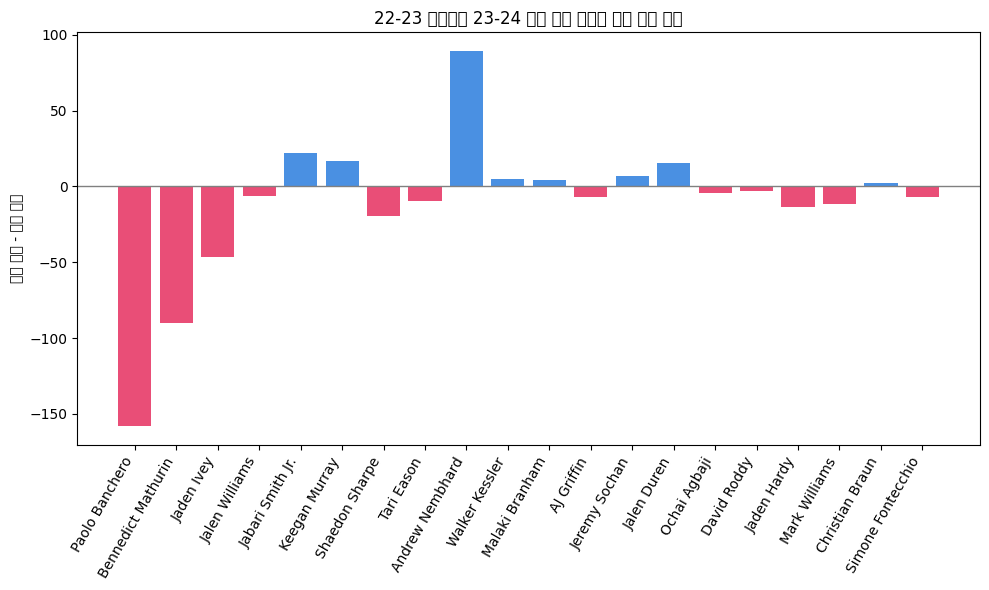

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# 선수명, 예상 총 득점, 실제 총 득점이 들어있는 DataFrame이 df라고 가정
# 예시: df = pd.DataFrame({...})

# 1. 오차(예상-실제) 컬럼 추가
df['득점 차이'] = df['예상 총 득점'] - df['실제 총 득점']

# 2. 상위 20명 기준으로 시각화 (원하면 전체로 확장 가능)
top_n = 20
players = df['선수명'][:top_n]
diff = df['득점 차이'][:top_n]

# 3. 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(players, diff, color=np.where(diff > 0, '#4A90E2', '#E94E77'))
plt.axhline(0, color='gray', linewidth=1)

plt.xticks(rotation=60, ha='right')
plt.ylabel('예상 득점 - 실제 득점')
plt.title('22-23 루키들의 23-24 시즌 예상 득점과 실제 득점 차이')
plt.tight_layout()
plt.show()


/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 46301 (\N{HANGUL SYLLABLE DEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-67-1961059406.py:19: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans

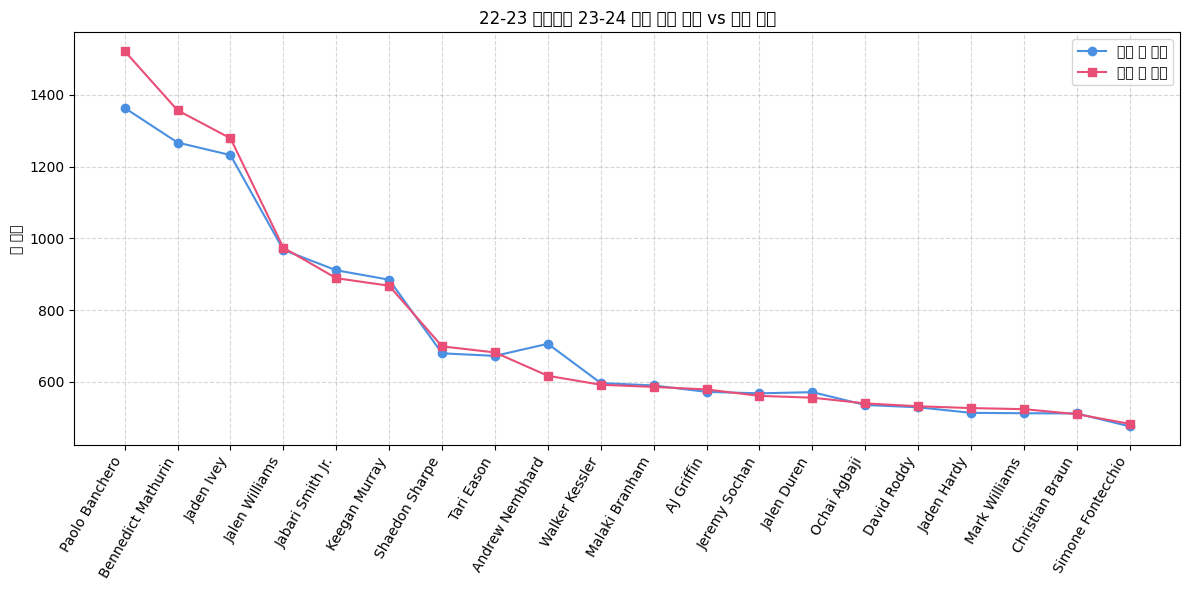

In [67]:
import matplotlib.pyplot as plt

# 선수명, 예상 총 득점, 실제 총 득점이 들어있는 DataFrame이 df라고 가정
# 예시: df = pd.DataFrame({...})

top_n = 20  # 상위 20명만 보기 (원하면 전체로 확장)
players = df['선수명'][:top_n]
pred = df['예상 총 득점'][:top_n]
actual = df['실제 총 득점'][:top_n]

plt.figure(figsize=(12, 6))
plt.plot(players, pred, marker='o', label='예상 총 득점', color='#4A90E2')
plt.plot(players, actual, marker='s', label='실제 총 득점', color='#E94E77')
plt.xticks(rotation=60, ha='right')
plt.ylabel('총 득점')
plt.title('22-23 루키들의 23-24 시즌 예상 득점 vs 실제 득점')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [68]:
# 예상 총 득점과 실제 총 득점의 상관계수 계산
correlation = df['예상 총 득점'].corr(df['실제 총 득점'])
print(f"예상 득점과 실제 득점의 상관계수: {correlation:.3f}")


예상 득점과 실제 득점의 상관계수: 0.998
